In [33]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchdiffeq import odeint

In [4]:
def pbpk_three_comp(t,y,Qk,Qt,Kpk,Kpt,CL,Vv,Vk,Vt,Dose):
    V,K,T = y
    dVdt= (Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T 
    dKdt= (Qk/Vk) * Kpk * V - (Qk/Vk)*K - (CL/Vk)*K
    dTdt= (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt,dKdt,dTdt]

In [5]:
y0=[0,0,0]
tspan = (0,100)
Dose= 100
Qk,Qt,Kpk,Kpt,CL,Vv,Vk,Vt=2, 1, 3, 0.5, 5, 10, 5, 8

In [6]:
sol = solve_ivp(pbpk_three_comp, tspan, y0, args=(Qk,Qt,Kpk,Kpt,CL,Vv,Vk,Vt,Dose), t_eval=np.linspace(0,100,100))

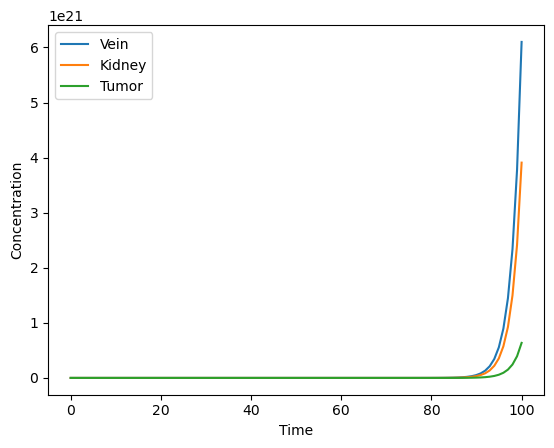

In [7]:
plt.plot(sol.t, sol.y[0], label='Vein')
plt.plot(sol.t, sol.y[1], label='Kidney')
plt.plot(sol.t, sol.y[2], label='Tumor')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [10]:
#Adding some non linearity by adding Michaelis-Menten kinetics
def michaelis_menten(C, Vmax, Km):
    return Vmax * C / (Km + C)


In [11]:
def metabol_pbpk_three_comp(t, y, Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose):
    V, K, T = y
    metabolism_rate = michaelis_menten(K, Vmax, Km)
    dVdt = (Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T 
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K - metabolism_rate
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt, dKdt, dTdt]

In [12]:
params = {
    "Qk": 1.0, "Qt": 0.5,
    "Kpk": 0.8, "Kpt": 0.5,
    "Vmax": 0.1, "Km": 0.1,
    "Vv": 1.0, "Vk": 0.5, "Vt": 0.3,
    "Dose": 1.0
}
y0 = [0, 0, 0]

t_span = [0, 24] 
t_eval = np.linspace(t_span[0], t_span[1], 100)


sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)




In [24]:
def simulate_pbpk_model(y0, params, t_span, t_eval):
    sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)
    return sol.y
initial_conditions_range = {
    "V": (0, 1),
    "K": (0, 1),
    "T": (0, 1)
}

In [42]:
data_samples = []
for _ in range(10000):
    y0 = [np.random.uniform(low, high) for low, high in initial_conditions_range.values()]
    sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)
    data_samples.append(sol.y)  
data_samples = np.array(data_samples)

In [52]:
data_samples.shape

(10000, 3, 100)

In [43]:
data_samples_reshaped = data_samples.reshape(data_samples.shape[0], -1)  
train,test=train_test_split(data_samples_reshaped, test_size=0.2,random_state=42)

In [44]:
train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

In [45]:
class NLPBPKModel(nn.Module):
    def __init__(self):
        super(NLPBPKModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,3)
                )
    def forward(self, y):
        return self.net(y)

In [51]:
class HybridODELSTMModel(nn.Module):
    def __init__(self, ode_func, param_dims, hidden_size):
        super().__init__()
        self.ode_func = ode_func
        self.ode_solver = odeint 
        self.param_dims = param_dims
        self.lstm = nn.LSTM(input_size=3 + param_dims, hidden_size=hidden_size)  

    def forward(self, t, x0, params):
        ode_pred = self.ode_solver(self.ode_func, x0, t, method="dopri5", options=dict(args=params))         
        lstm_out, _ = self.lstm(ode_pred.unsqueeze(1))
        return lstm_out[:, -1, :]       


In [46]:
pbpk_model= NLPBPKModel()
optimizer = torch.optim.Adam(pbpk_model.parameters(), lr=1e-3)
criterion= nn.MSELoss()

In [47]:
train_dataset = TensorDataset(train_tensor)
test_dataset = TensorDataset(test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
def train_and_validate(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train() 
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        total_train_loss = 0
        for batch in train_loader:
            y_batch = batch[0]
            optimizer.zero_grad()
            y_pred = model(y_batch)
            loss = criterion(y_pred, y_batch)            
            loss.backward()
            optimizer.step()           
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                y_batch = batch[0]
                y_pred = model(y_batch)
                loss = criterion(y_pred, y_batch)           
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)      
        model.train() 
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}') 
    return train_losses, val_losses


In [50]:

train_losses, val_losses = train_and_validate(pbpk_model, train_loader, test_loader, optimizer, criterion, 100)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x300 and 3x128)

In [65]:
# Three-Compartment ODE Model 
def three_comp_ode(t, y, Qk=Qk, Qt=Qt, Kpk=Kpk, Kpt=Kpt, Vv=Vv, Vk=Vk, Vt=Vt):
    V, K, T = y
    dVdt = - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt, dKdt, dTdt]

# Data Generation
def generate_data(num_samples, t_span, t_eval, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt, noise_std=0.1):
    data = []
    for _ in range(num_samples):
        x0 = np.random.rand(3)
        sol = solve_ivp(three_comp_ode, t_span, x0, t_eval=t_eval, args=(Qk, Qt, Kpk, Kpt, Vv, Vk, Vt))
        data.append(sol.y.T + np.random.randn(*sol.y.T.shape) * noise_std)
    return np.array(data)

# Parameter Values
Qk, Qt, Kpk, Kpt = 1.0, 0.5, 0.8, 0.3 
Vv, Vk, Vt = 2.0, 1.0, 0.5
t_span = [0, 24]
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Generate Data
data = generate_data(1000, t_span, t_eval, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt)
train_data, test_data = data[:800], data[800:] 

In [69]:
train_data.shape
#(800, 100, 3)

(800, 100, 3)

In [97]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
        )
    
    def forward(self, t, y):
        return self.net(y)

class HybridODELSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt):
        super(HybridODELSTMModel, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.ode_func = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.Qk = nn.Parameter(torch.tensor(Qk, dtype=torch.float32))
        self.Qt = nn.Parameter(torch.tensor(Qt, dtype=torch.float32))
        self.Kpk = nn.Parameter(torch.tensor(Kpk, dtype=torch.float32))
        self.Kpt = nn.Parameter(torch.tensor(Kpt, dtype=torch.float32))
        self.Vv = nn.Parameter(torch.tensor(Vv, dtype=torch.float32))
        self.Vk = nn.Parameter(torch.tensor(Vk, dtype=torch.float32))
        self.Vt = nn.Parameter(torch.tensor(Vt, dtype=torch.float32))
    
    def forward(self, x, t):
        lstm_out, (h_n, c_n) = self.lstm(x)
        h_n = h_n[-1]
        t = torch.linspace(0., self.seq_len, steps=self.seq_len, device=x.device)
        ode_sol = odeint(self.ode_func, h_n, t, method="dopri5")
        out = self.fc(ode_sol[-1])
        return out


In [98]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32  
train_dataset = TensorDataset(torch.tensor(train_data[:, :-1]), torch.tensor(train_data[:, 1:]))  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Similarly create test_dataset and test_loader
test_dataset = TensorDataset(torch.tensor(test_data[:, :-1]), torch.tensor(test_data[:, 1:]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [99]:
input_size = 3  # Since each timestep contains concentrations from 3 compartments
hidden_size = 128  # Example hidden size for LSTM
output_size = 3  # Predicting concentrations for 3 compartments at the next timestep
seq_len = 100  # Length of each input sequence
model = HybridODELSTMModel(input_size=3, hidden_size=128, output_size=3, seq_len=100, Qk=1.0, Qt=0.5, Kpk=0.8, Kpt=0.3, Vv=2.0, Vk=1.0, Vt=0.5)


Epoch 1: Train Loss = 174.9932, Val Loss = 3.2629
Validation loss decreased (inf --> 3.262929).  Saving model ...
Epoch 2: Train Loss = 4.1251, Val Loss = 0.3167
Validation loss decreased (3.262929 --> 0.316665).  Saving model ...
Epoch 3: Train Loss = 0.3486, Val Loss = 0.0734
Validation loss decreased (0.316665 --> 0.073402).  Saving model ...
Epoch 4: Train Loss = 0.0587, Val Loss = 0.0333
Validation loss decreased (0.073402 --> 0.033308).  Saving model ...
Epoch 5: Train Loss = 0.0316, Val Loss = 0.0368
EarlyStopping counter: 1 out of 20
Epoch 6: Train Loss = 0.0319, Val Loss = 0.0400
EarlyStopping counter: 2 out of 20
Epoch 7: Train Loss = 0.0287, Val Loss = 0.0326
Validation loss decreased (0.033308 --> 0.032617).  Saving model ...
Epoch 8: Train Loss = 0.0310, Val Loss = 0.0333
EarlyStopping counter: 1 out of 20
Epoch 9: Train Loss = 0.0310, Val Loss = 0.0365
EarlyStopping counter: 2 out of 20
Epoch 10: Train Loss = 0.0296, Val Loss = 0.0401
EarlyStopping counter: 3 out of 20
Ep

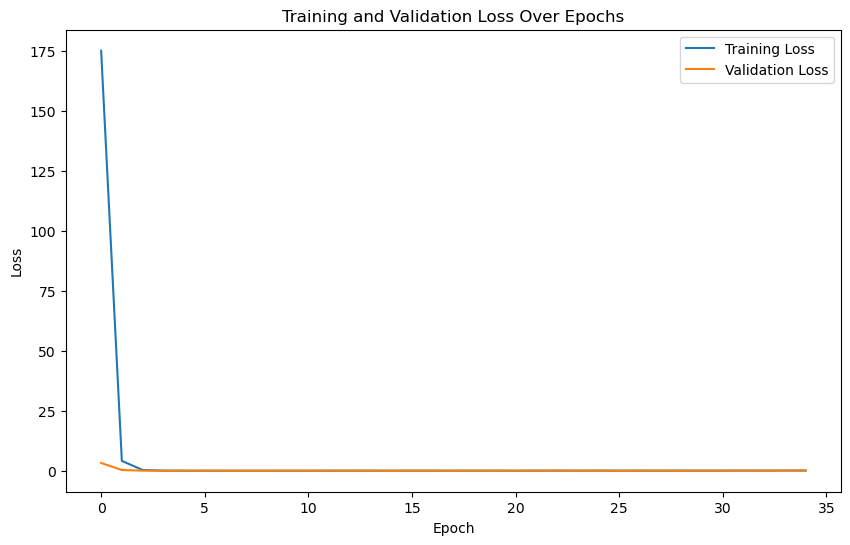

In [104]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.best_loss = val_loss

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=20, verbose=True)

train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    epoch_losses = []

    for x, y in train_loader:
        x, y = x.float(), y.float()
        t_eval_tensor = torch.linspace(0., model.seq_len, steps=model.seq_len, device=x.device)
        
        optimizer.zero_grad()
        preds = model(x, t_eval_tensor)
        y_true_adjusted = y[:, -1, :]
        loss = criterion(preds, y_true_adjusted)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)

    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.float(), y.float()
            preds = model(x, t_eval_tensor)
            y_true_adjusted = y[:, -1, :]
            val_loss = criterion(preds, y_true_adjusted)
            val_epoch_losses.append(val_loss.item())
    
    val_loss = np.mean(val_epoch_losses)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [106]:
y_preds

NameError: name 'y_preds' is not defined

Test Loss: 0.1856


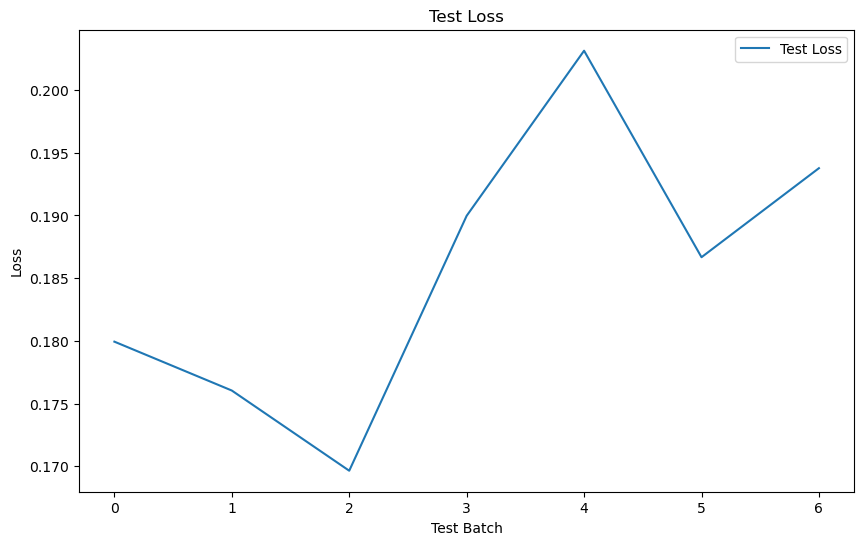

In [107]:
test_losses = []
model.eval()
ys = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.float()
        t_eval_tensor = torch.linspace(0., model.seq_len, steps=model.seq_len, device=x.device)
        y_true = y.float()

        preds = model(x, t_eval_tensor)
        y_true_adjusted = y_true[:, -1, :]
        ys.append(y_true_adjusted)
        loss = criterion(preds, y_true_adjusted)

        test_losses.append(loss.item())

test_loss = np.mean(test_losses)
print(f"Test Loss: {test_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Test Batch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


In [108]:
ys

[tensor([[ 0.6426,  0.4318,  0.2220],
         [ 0.3605,  0.3719,  0.1443],
         [ 0.3024,  0.2718,  0.2453],
         [ 0.7975,  0.5448,  0.1181],
         [ 0.7607,  0.4650,  0.1904],
         [ 0.4489,  0.4339,  0.1630],
         [ 1.0127,  0.5219,  0.2902],
         [ 0.3525,  0.3797,  0.4070],
         [ 0.6124,  0.5185,  0.2511],
         [ 0.5871,  0.3506,  0.1145],
         [ 0.5247,  0.1258,  0.0710],
         [ 0.8625,  0.7125,  0.2338],
         [ 0.6842,  0.3904,  0.0579],
         [ 0.5771,  0.4930,  0.0797],
         [ 0.1574,  0.0969,  0.0101],
         [ 0.3596, -0.0264, -0.1449],
         [ 0.1738,  0.4750, -0.0094],
         [ 0.7058,  0.6284,  0.3473],
         [ 0.5521,  0.4833,  0.2496],
         [ 0.3463,  0.2399,  0.1716],
         [ 0.4525,  0.1772,  0.0951],
         [ 0.5219,  0.4312,  0.1987],
         [ 0.2677,  0.2892, -0.0029],
         [ 0.4366,  0.0855,  0.2556],
         [ 0.3368,  0.5808,  0.1295],
         [ 0.2820,  0.1640, -0.0649],
         [ 0

In [127]:
train_data.shape

(800, 100, 3)

In [125]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
        )
    
    def forward(self, t, y):
        return self.net(y)

class HybridODELSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(HybridODELSTMModel, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.ode_func = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, t_span):
        lstm_out, (h_n, c_n) = self.lstm(x)
        h_n = h_n[-1]
        ode_sol = odeint(self.ode_func, h_n, t_span, method="dopri5")
        out = self.fc(ode_sol[-1])
        return out

def three_comp_ode(t, y, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt):
    V, K, T = y.unbind()
    dVdt = - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return torch.stack([dVdt, dKdt, dTdt])



In [130]:
def train_pinn(model, train_loader, optimizer, criterion, num_epochs, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt,t_span_tensor):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.float(), y.float()
            optimizer.zero_grad()
            
            # Forward pass: compute predictions
            preds = model(x, t_span_tensor)
            y_true_adjusted = y[:, -1, :]
            
            # Compute the MSE loss (data-fidelity term)
            mse_loss = criterion(preds, y_true_adjusted)
            
            # Calculate derivatives with respect to time
            d_preds = torch.autograd.grad(outputs=preds, inputs=t_span_tensor, 
                                      grad_outputs=torch.ones_like(preds), 
                                      create_graph=True, retain_graph=True)[0] 

            # Evaluate your PBPK ODE with predictions
            ode_evals = three_comp_ode(t_span_tensor, preds, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt) 

            # Physics loss (compare predicted derivatives to ODE output)
            physics_loss += criterion(d_preds, ode_evals) 
            
            # Total loss is the sum of data-fidelity and physics-fidelity terms
            loss = mse_loss #+ physics_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
    
    return model

# Instantiate the model
model = HybridODELSTMModel(input_size, hidden_size, output_size, seq_len)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

# Define the time span tensor outside the loop for efficiency
t_span_tensor = torch.linspace(0., seq_len, steps=seq_len, device='cuda' if torch.cuda.is_available() else 'cpu', requires_grad=True).float()  


# Train the model with PINN loss
model = train_pinn(model, train_loader, optimizer, criterion, 100, Qk, Qt, Kpk, Kpt, Vv, Vk, Vt,t_span_tensor)


ValueError: too many values to unpack (expected 3)